In [1]:
# --- INSTALLING LIBRARIES ---
!pip install --upgrade transformers accelerate datasets scikit-learn -q

# --- IMPORTING LIBRARIES ---
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, RobertaModel, TrainingArguments, Trainer 
from datasets import Dataset, DatasetDict
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import shutil # Import for Part 5

RNG = 42

# --- LOADING THE DATASET ---

# ✅ FIXED PATH BELOW
FILE_PATH = '/kaggle/input/composite-2-194k-data-roberta-text/Composite2_194k data.csv' 

print(f"Loading dataset from: {FILE_PATH}")

try:
    df = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print("\n❌ ERROR: File not found!")
    print(f"Please verify the path: {FILE_PATH}")
    print("Tip: In Kaggle, check the 'Input' section on the right sidebar to copy the exact path.")
    raise

# --- SANITY CHECK ---
needed_cols = [
    'title', 'reviewText', 'audienceScore', 'tomatoMeter', 'runtimeMinutes',
    'genre', 'language_encoded', 'director_encoded', 'target_label'
]

missing = [c for c in needed_cols if c not in df.columns]
if missing:
    raise ValueError(f"❌ CRITICAL ERROR: Your CSV is missing these columns: {missing}")

print("--- Part 1: Setup and Data Loading Complete (Kaggle Version) ---")
print(f"Dataset loaded with {df.shape[0]} rows.")
print(f"Target Distribution:\n{df['target_label'].value_counts().sort_index()}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 111.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.9/380.9 kB 27.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 130.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 97.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5

2025-11-26 09:11:24.522742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764148284.738261      20 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764148284.804453      20 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Loading dataset from: /kaggle/input/composite-2-194k-data-roberta-text/Composite2_194k data.csv
--- Part 1: Setup and Data Loading Complete (Kaggle Version) ---
Dataset loaded with 194784 rows.
Target Distribution:
target_label
0    55029
1    66081
2    73674
Name: count, dtype: int64


In [2]:
# --- PART 2: PREPROCESSING & FEATURE ENGINEERING ---

import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from packaging import version
import sklearn

# Ensure 'df' and 'RNG' exist from Part 1
if 'df' not in globals():
    raise ValueError("❌ 'df' is missing! Please run Part 1 to load the data first.")

# --- CLEANING ---
print("Cleaning data...")
df = df.dropna(subset=['reviewText', 'target_label']).copy()
# Map 'target_label' to the standard 'label' column expected by HF
df['label'] = df['target_label'].astype(int)

class_names = ['Negative', 'Neutral', 'Positive']
N_CLASSES = 3

# Text Prep
# 🚨 CRITICAL CHANGE: Only using reviewText for the combined_text field 🚨
df['combined_text'] = df['reviewText']

# --- STRATIFIED SPLIT ---
print("Splitting data (Stratified)...")
train_idx, test_idx = train_test_split(
    df.index, test_size=0.2, random_state=RNG, stratify=df['label']
)
train_df = df.loc[train_idx].reset_index(drop=True)
test_df  = df.loc[test_idx].reset_index(drop=True)

y_train = train_df['label'].values.astype(int)

# ==========================================
# CRITICAL: CALCULATE CLASS WEIGHTS
# ==========================================
print("Calculating class weights...")
# This forces the model to pay attention to minority classes
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("\n⚖️ Calculated Class Weights (Neg, Neu, Pos):")
print(class_weights)
print("(The model will use these to penalize mistakes on smaller classes more heavily)")

# ==========================================
# FEATURE ENGINEERING (Text-Only)
# 🚨 CRITICAL CHANGE: Removing ALL Non-Text Feature Processing 🚨
# Setting placeholders (Dummy Scalers/MLB) to ensure Part 3 runs smoothly 
# by returning zero-dimension arrays for non-text features.
# ==========================================
print("Starting Feature Engineering (Text-Only: ReviewText)...")

# Placeholder definitions for missing features to prevent downstream errors
NUMERIC_COLS = []
train_medians = pd.Series()

# Create dummy objects that return empty arrays for numeric/categorical features
scaler = type('DummyScaler', (object,), {'transform': lambda self, x: np.zeros((len(x), 0), dtype=np.float32)})()
mlb = type('DummyMLB', (object,), {'transform': lambda self, x: np.zeros((len(x), 0), dtype=np.float32)})()
# Dummy variables needed for Part 3's required_vars check
dir_train_block = np.zeros((len(train_df), 0), dtype=np.float32)
dir_test_block  = np.zeros((len(test_df), 0), dtype=np.float32) 

print("--- Part 2: Preprocessing & Weights Complete (Text-Only) ---")

Cleaning data...
Splitting data (Stratified)...
Calculating class weights...

⚖️ Calculated Class Weights (Neg, Neu, Pos):
tensor([1.1799, 0.9825, 0.8813])
(The model will use these to penalize mistakes on smaller classes more heavily)
Starting Feature Engineering (Text-Only: ReviewText)...
--- Part 2: Preprocessing & Weights Complete (Text-Only) ---


In [3]:
# --- PART 3: DATASET CREATION & TOKENIZATION ---

import numpy as np
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer

# Ensure prerequisites from Part 2 exist
required_vars = ['train_df', 'test_df', 'dir_train_block', 'dir_test_block', 'scaler', 'mlb', 'train_medians']
if not all(v in globals() for v in required_vars):
    raise ValueError("❌ Missing variables from Part 2. Please run the previous cell first.")

# Define helper function
# 🚨 CHANGE: Removed 'dir_block' from parameters.
def build_features(split_df):
    out = {}
    out['combined_text'] = split_df['combined_text'].tolist()
    out['label'] = split_df['label'].astype(int).tolist()

    # Numeric (Will be zero-dimension via DummyScaler)
    # Note: We must pass a DataFrame with columns that match the fit data, 
    # but since the model is text-only, we pass a dummy list.
    numeric = split_df[['tomatoMeter']].copy().fillna(train_medians) 
    out['numerical_features'] = scaler.transform(numeric.values).astype(np.float32)

    # Categorical (Will be zero-dimension via DummyMLB)
    genre_list = [[]] * len(split_df) # Pass empty lists to the DummyMLB
    # 🚨 CRITICAL CHANGE: Only Genre is used for categorical features, but it's empty! 🚨
    out['categorical_features'] = mlb.transform(genre_list).astype(np.float32)
    
    return out

print("Building features dictionaries (Text-Only)...")
train_feats = build_features(train_df)
test_feats  = build_features(test_df)

# Dimensions
# 🚨 CRITICAL CHANGE: Set feature counts to 0 🚨
num_numerical_features = 0
num_categorical_features = 0
print(f"Feature Dims: Numeric={num_numerical_features}, Categorical={num_categorical_features}")

# HF Dataset
print("Converting to Hugging Face Datasets...")
raw_datasets = DatasetDict({
    'train': Dataset.from_dict(train_feats),
    'test':  Dataset.from_dict(test_feats),
})

# Tokenization
MODEL_CHECKPOINT = "roberta-base" 

print(f"Downloading Tokenizer ({MODEL_CHECKPOINT})...")
try:
    tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
except Exception as e:
    print("\n❌ ERROR: Could not download tokenizer.")
    print("Please check if 'Internet' is enabled in the Kaggle Notebook settings (Right Sidebar > Settings > Internet 'On').")
    raise e

def tokenize_fn(examples):
    return tokenizer(examples["combined_text"], padding="max_length", truncation=True, max_length=256)

print("Tokenizing dataset (this may take a moment)...")
tokenized_datasets = raw_datasets.map(tokenize_fn, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["combined_text"])
tokenized_datasets.set_format("torch")

print(f"--- Part 3: Dataset Ready & Tokenized (Feature Dims: Num={num_numerical_features}, Cat={num_categorical_features}) ---")

Building features dictionaries (Text-Only)...
Feature Dims: Numeric=0, Categorical=0
Converting to Hugging Face Datasets...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing dataset (this may take a moment)...


Map:   0%|          | 0/155827 [00:00<?, ? examples/s]

Map:   0%|          | 0/38957 [00:00<?, ? examples/s]

--- Part 3: Dataset Ready & Tokenized (Feature Dims: Num=0, Cat=0) ---


In [4]:
# --- PART 4: MODEL SETUP & TRAINING (KAGGLE VERSION - FIXED) ---\n

import torch
import torch.nn as nn
from transformers import Trainer, TrainingArguments, RobertaModel 
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import numpy as np
import os

# --- SAFETY CHECK ---\n
if 'class_weights' not in globals():
    raise ValueError("❌ 'class_weights' is missing! Please run Part 2 first.")
if 'MODEL_CHECKPOINT' not in globals() or 'num_numerical_features' not in globals() or 'num_categorical_features' not in globals():
    raise ValueError("❌ Model checkpoint or feature dimensions missing! Please run Part 3 first.")

# --- MODEL ARCHITECTURE ---
class MultimodalClassifier(nn.Module):
    def __init__(self, num_labels, num_numerical, num_categorical):
        super().__init__()
        self.roberta = RobertaModel.from_pretrained(MODEL_CHECKPOINT) 
        self.dropout = nn.Dropout(0.2)
        # 🚨 CRITICAL CHANGE: Input size is RoBERTa output + 0 + 0 🚨
        self.classifier = nn.Linear(
            self.roberta.config.hidden_size + num_numerical + num_categorical,
            num_labels
        )
        self.num_labels = num_labels

    def forward(self, input_ids, attention_mask, numerical_features, categorical_features, labels=None):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = self.dropout(roberta_output.last_hidden_state[:, 0])

        # The combined vector is now just pooled_output
        combined = torch.cat([pooled_output, numerical_features, categorical_features], dim=1)
        logits = self.classifier(combined)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return (loss, logits) if loss is not None else (None, logits)

# --- CUSTOM TRAINER (FIXED FOR DATAPARALLEL) ---
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs[1]

        if hasattr(model, "module"):
            classifier_layer = model.module.classifier
        else:
            classifier_layer = model.classifier

        # Move weights to the correct device
        weights = class_weights.to(classifier_layer.weight.device)

        # Weighted Loss Calculation
        loss_fct = nn.CrossEntropyLoss(weight=weights)
        loss = loss_fct(logits.view(-1, self.model.num_labels), labels.view(-1))

        return (loss, outputs) if return_outputs else loss

# --- DATA COLLATOR, METRICS, INITIALIZATION (No Change) ---
class MultimodalDataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer
    def __call__(self, features):
        batch = self.tokenizer.pad(
            [{"input_ids": f["input_ids"], "attention_mask": f["attention_mask"]} for f in features],
            return_tensors="pt"
        )
        batch['labels'] = torch.tensor([f['label'] for f in features], dtype=torch.long)
        batch['numerical_features'] = torch.stack([f['numerical_features'] for f in features])
        batch['categorical_features'] = torch.stack([f['categorical_features'] for f in features])
        return batch

def compute_metrics(pred):
    labels = pred.label_ids
    
    if isinstance(pred.predictions, tuple):
        predictions = pred.predictions[0]
    else:
        predictions = pred.predictions
        
    preds = predictions.argmax(-1)

    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    
    return {'accuracy': acc, 'f1_weighted': f1, 'precision': prec, 'recall': rec}

# 🚨 CHANGE: Pass updated feature counts (0, 0) to the model
model = MultimodalClassifier(N_CLASSES, num_numerical_features, num_categorical_features)

# 🚨 CHANGE: Update the output directory name
OUTPUT_DIR = "/kaggle/working/Model_Results_3Class_Weighted_RoBERTa_Base_TextOnly_C2" 

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    learning_rate=2e-5,
    per_device_train_batch_size=16, 
    per_device_eval_batch_size=16,
    num_train_epochs=3, 
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_weighted",  
    greater_is_better=True,
    save_total_limit=2,
    report_to="none",
    logging_steps=100,
    fp16=True 
)

trainer = WeightedTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=MultimodalDataCollator(tokenizer),
    compute_metrics=compute_metrics,
)

print(f"--- Part 4: RoBERTa-base Weighted Training Setup Complete (Text-Only, 3 Epochs) ---")
print(f"Saving checkpoints to: {OUTPUT_DIR}")
print(f"Training Batch Size: {training_args.per_device_train_batch_size}")
trainer.train()
print("--- Training Complete ---")

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


--- Part 4: RoBERTa-base Weighted Training Setup Complete (Text-Only, 3 Epochs) ---
Saving checkpoints to: /kaggle/working/Model_Results_3Class_Weighted_RoBERTa_Base_TextOnly_C2
Training Batch Size: 16


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,F1 Weighted,Precision,Recall
1,0.713800,0.680837,0.676720,0.662051,0.673583,0.676720
2,0.625900,0.691807,0.692250,0.682977,0.684029,0.692250
3,0.560500,0.702580,0.696332,0.691817,0.690068,0.696332


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


--- Training Complete ---



--- Final Evaluation on Test Set ---


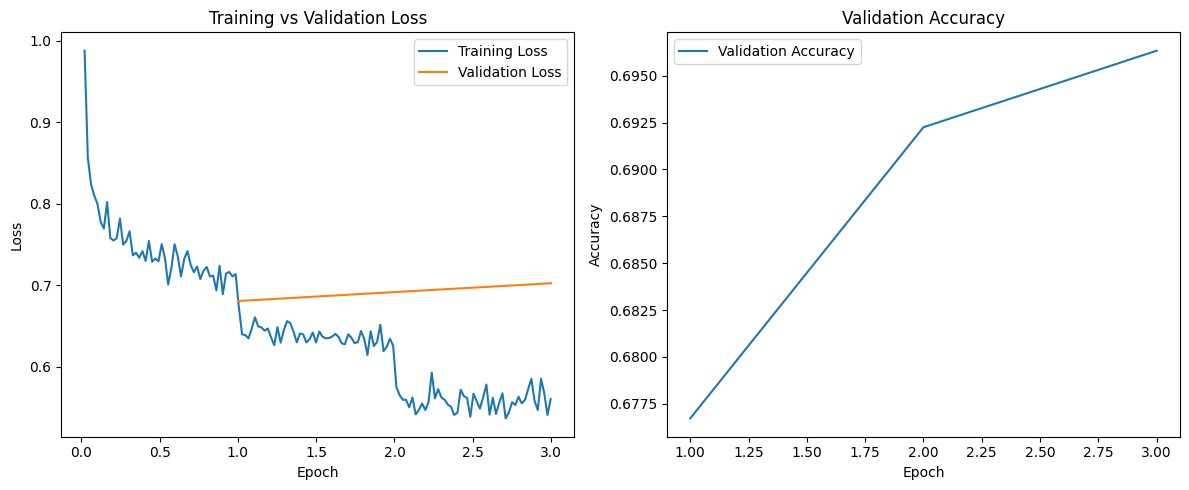

Generating predictions...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



--- Classification Report ---
              precision    recall  f1-score   support

    Negative     0.6738    0.7167    0.6946     11006
     Neutral     0.5952    0.5194    0.5547     13216
    Positive     0.7873    0.8398    0.8127     14735

    accuracy                         0.6963     38957
   macro avg     0.6854    0.6920    0.6873     38957
weighted avg     0.6901    0.6963    0.6918     38957



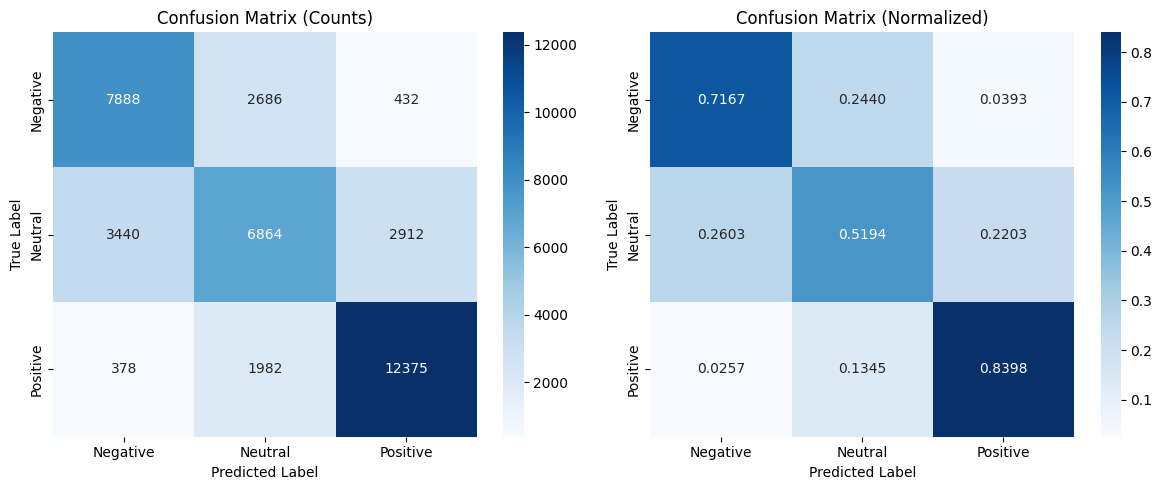

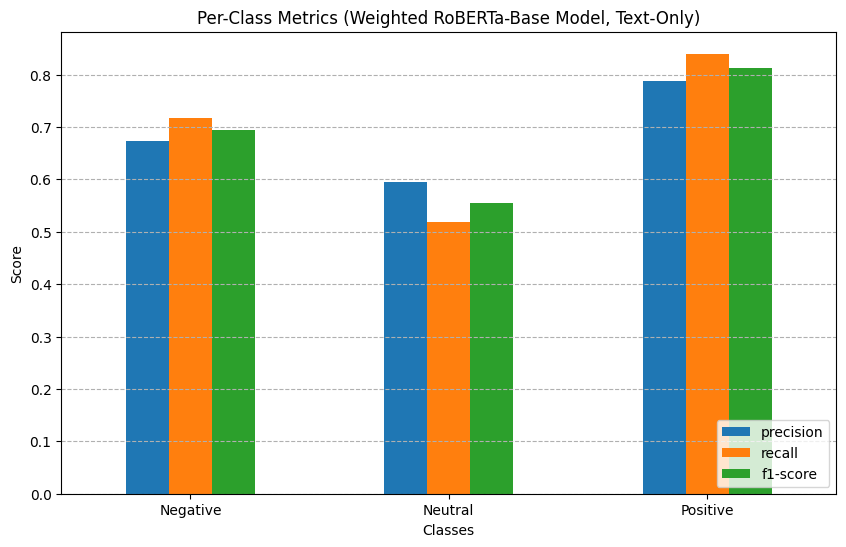


💾 Saving model to /kaggle/working/Final_Model_3Class_RobertaB_TextOnly_C2...
📦 Zipping model for easy download...
✅ DONE! You can now download 'Final_Model_3Class_RobertaB_TextOnly_C2.zip' from the 'Output' tab on the right.


In [5]:
# --- PART 5: EVALUATION & SAVING (KAGGLE VERSION) ---

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import shutil # For zipping the model

# ==========================
# EVALUATE • REPORT • PLOTS • SAVE
# ==========================
print("\n--- Final Evaluation on Test Set ---")

# 1. PLOT LOSS CURVES
# Access logs
log_history = trainer.state.log_history
train_logs = [log for log in log_history if ('loss' in log and 'eval_loss' not in log)]
eval_logs = [log for log in log_history if ('eval_loss' in log)]

plt.figure(figsize=(12, 5))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot([log.get('epoch', i) for i, log in enumerate(train_logs, 1)], [log['loss'] for log in train_logs], label='Training Loss')
plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)], [log['eval_loss'] for log in eval_logs], label='Validation Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Training vs Validation Loss'); plt.legend()


# Accuracy Plot
plt.subplot(1, 2, 2)
if len(eval_logs) > 0 and 'eval_accuracy' in eval_logs[0]:
    plt.plot([log.get('epoch', i) for i, log in enumerate(eval_logs, 1)], [log['eval_accuracy'] for log in eval_logs], label='Validation Accuracy')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Validation Accuracy'); plt.legend()
plt.tight_layout(); plt.show()


# 2. PREDICTIONS (FIXED & SAFE)
print("Generating predictions...")
preds_output = trainer.predict(tokenized_datasets["test"])

# --- SAFETY CHECK START ---
if isinstance(preds_output.predictions, tuple):
    logits = preds_output.predictions[0]  # Extract logits if it's a tuple
else:
    logits = preds_output.predictions     # Use directly if it's an array
# --- SAFETY CHECK END ---

pred_labels = np.argmax(logits, axis=-1)
true_labels = np.array(tokenized_datasets["test"]["label"])

# 3. CLASSIFICATION REPORT (Updated to 4 decimal places)
print("\n--- Classification Report ---")
report_dict = classification_report(true_labels, pred_labels, target_names=class_names, output_dict=True)

# digits=4 for detailed precision
print(classification_report(true_labels, pred_labels, target_names=class_names, digits=4))

# 4. CONFUSION MATRIX (Updated to 4 decimal places)
cm = confusion_matrix(true_labels, pred_labels)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 5))

# Counts (Integers)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Counts)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Normalized (Floats with 4 decimals)
plt.subplot(1, 2, 2)
sns.heatmap(cm_norm, annot=True, fmt='.4f', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Normalized)')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# 5. PER-CLASS BAR CHART
report_df = pd.DataFrame(report_dict).transpose()
report_df_classes = report_df.loc[[cn for cn in class_names if cn in report_df.index]]
ax = report_df_classes[['precision', 'recall', 'f1-score']].plot(kind='bar', figsize=(10, 6))
plt.title('Per-Class Metrics (Weighted RoBERTa-Base Model, Text-Only)')
plt.xlabel('Classes'); plt.ylabel('Score')
plt.xticks(rotation=0); plt.grid(axis='y', linestyle='--'); plt.legend(loc='lower right')
plt.show()

# 6. SAVE (KAGGLE SPECIFIC)
# Kaggle saves to /kaggle/working/
FINAL_MODEL_DIR = "Final_Model_3Class_RobertaB_TextOnly_C2" 
FINAL_MODEL_PATH = f"/kaggle/working/{FINAL_MODEL_DIR}"

print(f"\n💾 Saving model to {FINAL_MODEL_PATH}...")
trainer.save_model(FINAL_MODEL_PATH)

# --- ZIP FOR DOWNLOAD ---
# Kaggle makes it hard to download folders. We zip it so you can download 1 file.
print("📦 Zipping model for easy download...")
shutil.make_archive(f"/kaggle/working/{FINAL_MODEL_DIR}", 'zip', FINAL_MODEL_PATH)

print(f"✅ DONE! You can now download '{FINAL_MODEL_DIR}.zip' from the 'Output' tab on the right.")